### Instructor Demo: Financial Forecasting Part II

This program executes `1000` simulations of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of average daily returns derived from the sample mean and standard deviation. Then, the program calculates a `95%` confidence interval of stock price outcomes for `TSLA`. 

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NASDAQ',
     'id': 'bb05f61a-daf9-4fff-9e26-e0adaf23fbb0',
     'marginable': True,
     'name': 'HBT Financial, Inc. Common Stock',
     'shortable': True,
     'status': 'active',
     'symbol': 'HBT',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '38b93a03-cd62-4158-acfc-78b0ef46da46',
     'marginable': True,
     'name': 'Franklin FTSE Hong Kong ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'FLHK',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'd3f264d8-99ca-4261-8a0b-98ef4534bcfd',
     'marginable': True,
     'name': 'Hennessy Capital Acquisition Corp. IV Unit',
     'shortable': False,
     'status': 'active',
     'symbol': 'HCACU',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': Fals

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,HBT
1,FLHK
2,HCACU
3,HCAP
4,HCC
5,HCCHR
6,ARB
7,AXP
8,DEO
9,DSS


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-05-04", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-04", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                      
                             open      high       low    close   volume
2019-05-06 00:00:00-04:00  250.10  258.3499  248.5000  255.335  9546203
2019-05-07 00:00:00-04:00  256.80  257.2100  245.1000  247.060  9542822
2019-05-08 00:00:00-04:00  246.94  250.5990  244.2000  244.760  5757805
2019-05-09 00:00:00-04:00  242.00  243.6800  236.9434  241.980  6455536
2019-05-10 00:00:00-04:00  239.75  241.9900  236.0200  239.510  6716345

### Drop Extraneous Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-06,255.335
2019-05-07,247.060
2019-05-08,244.760
2019-05-09,241.980
2019-05-10,239.510


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-06,NaN
2019-05-07,-0.032408
2019-05-08,-0.009309
2019-05-09,-0.011358
2019-05-10,-0.010207


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.005547077748894644

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.048768398745483464

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations, trading days, and get last closing price of TSLA from DataFrame
num_simulations = 1000
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_tsla_prices = [tsla_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_tsla_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_tsla_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,...,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000,761.210000
1,777.939249,748.472175,744.778343,798.609997,730.957561,749.351765,753.999189,797.887520,720.103834,773.413451,...,737.596999,770.083039,741.651363,762.326377,673.466627,748.816583,762.579871,786.497455,707.665993,759.361304
2,757.213171,715.015165,738.716300,776.562384,760.732861,730.241942,820.355965,753.731396,760.413263,815.003010,...,755.234545,793.176488,697.605445,750.283125,687.223143,740.638217,850.394741,793.156729,720.888107,713.387710
3,748.813853,739.706479,739.460440,799.973293,744.804302,724.716158,808.233513,809.772321,734.950748,842.258014,...,712.495770,705.828656,693.284678,718.520300,681.308721,750.448398,788.941985,791.589642,700.679810,753.211931
4,788.538371,718.198864,697.030268,841.644518,797.000105,722.478180,756.415117,851.657442,729.398976,908.979949,...,738.113052,710.211839,792.913803,739.308780,745.239086,725.760402,822.568882,700.113957,684.494034,777.933459


### Plot the Multiple Simulations of Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3 Trading Days)

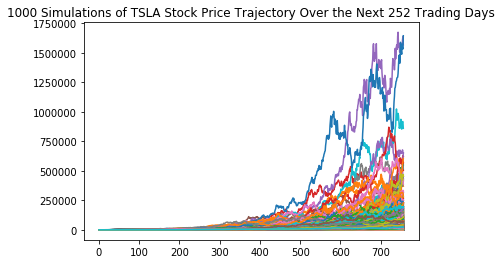

In [11]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a 252 * 3 trading day simulation
plot_title = f"{n+1} Simulations of TSLA Stock Price Trajectory Over the Next 252 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    21924.804005
Simulation 2    13874.811962
Simulation 3    37920.630986
Simulation 4    14941.839856
Simulation 5     4534.104184
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Prices on the Last Simulated Trading Day

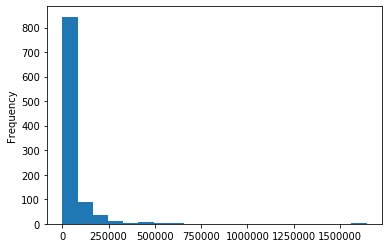

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

### View the Probability Distribution of Simulated Ending Price Ranges on the Last Simualted Trading Day

In [14]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(-1331.2549999999999, 82480.707]    0.844
(82480.707, 164649.297]             0.088
(164649.297, 246817.886]            0.037
(246817.886, 328986.475]            0.010
(411155.065, 493323.654]            0.008
(575492.243, 657660.833]            0.004
(493323.654, 575492.243]            0.004
(328986.475, 411155.065]            0.002
(1561515.316, 1643683.906]          0.002
(821998.012, 904166.601]            0.001
(1479346.727, 1561515.316]          0.000
(657660.833, 739829.422]            0.000
(904166.601, 986335.19]             0.000
(986335.19, 1068503.78]             0.000
(1068503.78, 1150672.369]           0.000
(1150672.369, 1232840.959]          0.000
(1232840.959, 1315009.548]          0.000
(1315009.548, 1397178.137]          0.000
(1397178.137, 1479346.727]          0.000
(739829.422, 821998.012]            0.000
Name: 756, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Stock Prices of TSLA

In [15]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025      1294.977654
0.975    285968.503818
Name: 756, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Prices 

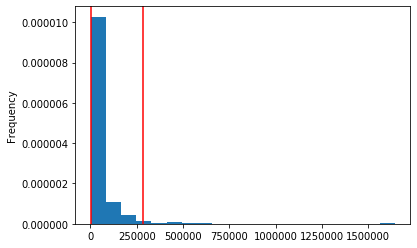

In [16]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in TSLA over the Next 3 Years (252 * 3) Trading Days

In [17]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - tsla_last_price) / tsla_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - tsla_last_price) / tsla_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in TSLA"
      f" over the next (252 * 3) trading days will end within in the range of"
      f" ${ending_investment_lower_bound} and ${ending_investment_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in TSLA over the next (252 * 3) trading days will end within in the range of $17012.094607145456 and $3756762.3102390873
